### Imports and Configuration

In [52]:
import gymnasium as gym

import time
import numpy as np
import matplotlib.pyplot as plt
import itertools
from tqdm.notebook import tqdm
import pandas as pd
import pickle

In [53]:
configuration = {

    # Parametrization bellow cannot be changed
    "lanes_count" : 10, # The environment must always have 10 lanes
    "vehicles_count": 50, # The environment must always have 50 other vehicles
    "duration": 120,  # [s] The environment must terminate never before 120 seconds
    "other_vehicles_type": "highway_env.vehicle.behavior.IDMVehicle", # This is the policy of the other vehicles
    "initial_spacing": 2, # Initial spacing between vehicles needs to be at most 2

    # Refer to refer to https://highway-env.farama.org/observations/ to change observation space type
    "observation": {
        "type": "Kinematics"
    },

    # Refer to refer to https://highway-env.farama.org/actions/ to change action space type
    "action": {
        "type": "DiscreteMetaAction",
    },

    # Parameterization bellow can be changed (as it refers mostly to the reward system)
    # "collision_reward": -10,  # The reward received when colliding with a vehicle. (Can be changed)
    # "reward_speed_range": [20, 30],  # [m/s] The reward for high speed is mapped linearly from this range to [0, HighwayEnv.HIGH_SPEED_REWARD]. (Can be changed)
    "simulation_frequency": 15, #15,  # [Hz] (Can be changed)
    "policy_frequency": 5, #5,  # [Hz] (Can be changed)

    "collision_reward": -100,  # The reward received when colliding with a vehicle.
    "right_lane_reward": 0.1,  # The reward received when driving on the right-most lanes, linearly mapped to
    # zero for other lanes.
    "high_speed_reward": 100,  # The reward received when driving at full speed, linearly mapped to zero for
    # lower speeds according to config["reward_speed_range"].
    "lane_change_reward": 0,  # The reward received at each lane change action.
    "reward_speed_range": [20, 30],
    
    # Parameters defined bellow are purely for visualiztion purposes! You can alter them as you please
    "screen_width": 800,  # [px]
    "screen_height": 600,  # [px]
    "centering_position": [0.5, 0.5],
    "scaling": 5,
    "show_trajectories": True,
    "render_agent": True,
    "offscreen_rendering": False
}

default_config = configuration.copy()

### Checking the environment 

In [132]:
occupancyGrid = configuration.copy()
occupancyGrid["observation"] =  {
    "type": "OccupancyGrid",
    # "vehicles_count": 50,
    "features": [
                "presence",
                #"x", "y", 
                #"vx", "vy"
                ],
    # "features_range": {
    #      "x": [-500, 500],
    #      "y": [-500, 500],
    #     "vx": [-20, 20],
    #     "vy": [-20, 20]
    # },
    "grid_size": [[-100, 100], [-100, 100]],    # X controls how many lanes, Y controls how far ahead
    "grid_step": [1, 1],
    #"absolute": False,                     # Not implemented in the library
    #"as_image": True,
    # "align_to_vehicle_axes" : True
}

# The higher the number, the more frequent the policy and the simulation frequencies, the slower the simulation
occupancyGrid["simulation_frequency"] = 15
occupancyGrid["policy_frequency"] = 1
occupancyGrid["normalize_reward"] = False

env = gym.make('highway-v0', render_mode='human', config=occupancyGrid)

obs, info = env.reset(seed = 30)
# Do one step
action = 3
obs, reward, done, truncated, info = env.step(action)
print("Reward:", reward)

env.close()

obs

Reward: 91.46669937980411


array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]], dtype=float32)

In [133]:
# Generate an episode of the environment and show the rewards and cumulative rewards
cum_reward = 0
with gym.make("highway-v0", config=occupancyGrid, render_mode='human') as env:
    obs = env.reset()
    for _ in range(1000):
        action = env.action_space.sample()
        obs, reward, done, truncated, info = env.step(action)
        cum_reward += reward
        print(reward, cum_reward)
        if done:
            break

50.06666666666667 50.06666666666667
91.52225493535967 141.58892160202635
98.60652722998472 240.19544883201107
99.81714601602411 340.0125948480352
-99.93333333333334 240.07926151470184


In [ ]:
class OccupancyGrid():
    def __init__(
            self,
            grid_size=[[-50, 50], [-50, 50]],  # X controls the lane-width, Y controls how far ahead
            grid_step=[1, 1],
            colision_reward=-100,
            skew_speed=1,
            policy=None,
            sim_frequency=10,
            policy_frequency=1,
            render_mode = 'human',
            seed = 50,
    ):
        """
        Occupancy view class constructor
        Arguments:
            grid_size: list of lists, the size of the grid in the x and y direction, where x controls the lane-width and y controls how far ahead. Lanes are 5m wide, and the car position is (0,0)
            grid_step: list, the step size of the grid in the x and y direction, in meters
            colision_reward: float, the reward to give when a colision occurs
            skew_speed: float, the skew speed to apply to the reward
            policy: function, the policy to use in the simulation
            sim_frequency: int, the frequency of the simulation
            policy_frequency: int, the frequency of the policy
            render_mode: str, the mode to render the simulation
            seed: int, the seed to use in the simulation
        """

        self.grid_size = grid_size
        self.grid_step = grid_step
        self.config = default_config.copy()
        self.config["observation"] =  {
            "type": "OccupancyGrid",
            "features": ["presence"],
            "grid_size": grid_size,    # X controls how many lanes, Y controls how far ahead
            "grid_step": grid_step,
        }
        self.config["simulation_frequency"] = sim_frequency
        self.config["policy_frequency"] = policy_frequency
        self.render_mode = render_mode
        self.seed = seed
        self.policy = policy
        self.colision_reward = colision_reward
        self.skew_speed = skew_speed
        self.initialize_states()


    def initialize_states(self):
        """
        Initialize the states of the occupancy grid
        """
        # Start the environment
        with gym.make('highway-v0', render_mode=self.render_mode, config=self.config) as env:
            obs, info = env.reset(seed = self.seed)
            self.current_obs = obs
            self.env = env
        
    def get_state(self):
        """
        Get the state of the environment
        """
        pass

    def test_env(self):
        """
        Function to test the environment with a random policy, or with a policy
        """
        obs, info = self.env.reset(seed = self.seed)
        self.current_obs = obs
        done = False
        while not done:
            # start = time.time()
            if self.policy is None:
                action = self.env.action_space.sample()
            else:
                action = self.policy()
            obs, reward, done, truncate, info = self.env.step(action)
            self.current_obs = obs
            print(self.get_state(type='lane-wise', decode=True), decode_meta_action(action), reward)
            time.sleep(1)
            # end = time.time()
            # print(f"Time taken: {end-start}")
        self.env.close()
        return info["score"]

# ------------------- SARSA -------------------    
class Sarsa(OccupancyGrid):
    def __init__(
        self,
        alpha=0.75,
        gamma=0.95,
        epsilon=0.6,
        print_stats=False,
        **kwargs,
        ):
        """
        SARSA class constructor
        Arguments:
            alpha: float, the learning rate
            gamma: float, the discount factor
            m: int, the number of episodes to train the agent for
            epsilon: float, the epsilon value for the epsilon-greedy policy
            print_stats: bool, whether to print the statistics during initialization
        """

        super().__init__(**kwargs)
        self.initialize_Q(print_stats)
        self.alpha, self.gamma, self.epsilon = alpha, gamma, epsilon

    def policy_Q(self, state):
        values = [self.Q[(state, action)] for action in range(5)]
        return np.argmax(values)   

    def initialize_Q(self, print_stats = False):
        # Combine the possible states with the possible actions
        keys = list(itertools.product(self.states, range(5)))       # 5 possible actions, 0-4: left, idle, right, accelerate, decelerate
        if len(keys) > 150000:
            print("Warning: The number of states is too large, consider reducing the number of states")
        if print_stats:
            print(f"Number of states: {len(keys)}")   
        self.Q = {key: 0 for key in keys}

    def epsilon_greedy(self, state):
        if np.random.rand() < self.epsilon:
            return np.random.randint(5)
        else:
            values = [self.Q[(state, action)] for action in range(5)]
            return np.argmax(values)
        
    def train(self, m=100, verbose=0): 
        env = gym.make('highway-v0', render_mode=None, config=self.config)
        obs, info = env.reset(seed = np.random.randint(1000))
        self.current_obs = obs
        done = False
        state = self.get_state()
        action = self.epsilon_greedy(state)
        q_explored = np.count_nonzero(list(self.Q.values()))
        for i in tqdm(range(m)):
            env.reset()
            cum_reward = 0
            done = False
            while not done:
                next_obs, reward, done, truncate, info = env.step(action)
                next_state = self.get_state()
                next_action = self.epsilon_greedy(next_state)

                print(next_state, decode_meta_action(next_action), reward) if verbose > 2 else None
                if self.Q[(state, action)] == 0:
                    q_explored += 1
                cum_reward += reward

                self.Q[(state, action)] += self.alpha*(reward + self.gamma*self.Q[(next_state, next_action)] - self.Q[(state, action)])
                state, action = next_state, next_action
                self.current_obs = next_obs
            print(f"Episode {i+1} completed, cumulative reward: {cum_reward}") if verbose > 0 else None
            print(f"Q explored: {100*q_explored/len(self.Q)}") if verbose > 1 else None
        env.close()

    def test(self):
        env = gym.make('highway-v0', render_mode=self.render_mode, config=self.config)
        obs, info = env.reset(seed = self.seed)
        self.current_obs = obs
        done = False
        state = self.get_state(self.state_type)
        action = self.policy_Q(state)
        while not done:
            next_obs, reward, done, truncate, info = env.step(action)
            next_state = self.get_state(self.state_type)
            next_action = self.policy_Q(next_state)
            state, action = next_state, next_action
            self.current_obs = next_obs
            print(next_state)
        env.close()
        return info["score"]

- grid_size=[[-50, 50], [-50, 50]],  # X controls the lane-width, Y controls how far ahead
- grid_step=[1, 1],
- n_closest=3,
- ss_bins=[5,6],
- crop_dist=[[-10,10], [-10,25]],
- policy=None,
- sim_frequency=15,
- policy_frequency=5,
- render_mode = 'human',
- seed = 50,

In [113]:
copyQ = a.Q.copy()

In [114]:
a = Sarsa(print_stats=True, epsilon=0.6, alpha=0.3, gamma=0.8)
a.Q = copyQ.copy()

Number of states: 540


!!! TODO !!!

- Use kinematics to substitute the current occupancy grid class

- He cannot know when he cant turn left or right because the lane is the final one

- Change the occupancy class to use occupancy grid with 5m grid size, 3 lanes and -30, 30 ahead

- Make a plot history 

- Check how many times each state is visited

- Check the action distribution, so as to see if slowing down is the most chosen action and the one with the best Q value

- Change the reward for colision, so that the agent goes faster

!!! IDEA WITH KINEMATICS !!!
- State space in this maner: (danger ahead, danger left, danger right, danger behind, lane position, (maybe) speed)
- Lane position can be 0 if in the middle, 1 if in the right, -1 if in the left

- We need speed, because if the speed is too fast, it might not be able to turn in time
- Actually, we could just increase the safety distance, and then we wouldn't need speed

In [123]:
a.train(m=100, verbose=2)

  0%|          | 0/100 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [118]:
count = 0
for keys, values in a.Q.items():
    if values != 0:
        count += 1

print(100*count/len(a.Q))

20.37037037037037


In [119]:
# Check the values for Q for this state (15, 30, 18, 18)
state = (30, 30, 18, 18)
for action in range(5):
    print(f"Action: {decode_meta_action(action)}, Q-value: {a.Q[(state, action)]}")

Action: LANE_LEFT, Q-value: -46.81659543807035
Action: IDLE, Q-value: -13.458657418241788
Action: LANE_RIGHT, Q-value: -12.65590344059557
Action: FASTER, Q-value: -7.4392318919133285
Action: SLOWER, Q-value: -8.453300283131032


In [120]:
a.test()

(10, 30, 18, 18)
(30, 30, 18, 6)
(30, 30, 18, 18)
(15, 30, 18, 18)
(5, 30, 18, 18)
(30, 30, 18, 18)
(30, 30, 18, 6)
(30, 30, 18, 12)
(15, 30, 18, 18)
(5, 30, 18, 18)
(5, 30, 18, 18)
(5, 30, 18, 18)
(5, 30, 18, 18)
(5, 30, 18, 18)
(5, 30, 18, 18)
(5, 30, 18, 18)
(5, 30, 18, 18)
(5, 30, 18, 18)
(5, 30, 18, 18)
(5, 30, 18, 18)
(5, 30, 18, 18)
(5, 30, 18, 18)
(5, 30, 18, 18)
(5, 30, 18, 18)
(5, 30, 18, 18)
(5, 30, 18, 18)
(5, 30, 18, 18)
(5, 30, 18, 18)
(5, 30, 18, 18)
(5, 30, 18, 18)
(5, 30, 18, 18)
(5, 30, 18, 18)
(5, 30, 18, 18)
(5, 30, 18, 12)
(5, 30, 18, 12)
(5, 30, 18, 12)
(10, 30, 18, 12)
(10, 30, 18, 12)
(30, 30, 12, 6)
(15, 30, 18, 12)
(10, 30, 18, 12)
(10, 30, 18, 6)
(30, 10, 6, 6)


KeyError: 'score'

In [132]:
new_occupancy = OcupancyGrid(render_mode=None)
# print(new_occupancy.x_bins, new_occupancy.y_bins, len(new_occupancy.states))
# new_occupancy.test_env()

___________________________
### Using kinematics

In [147]:
kinematics = configuration.copy()
kinematics["observation"] =  {
    "type": "Kinematics",
    "vehicles_count": 50,
    "features": ["x", "y", "vx", "vy"],
    # "features_range": {
    #     "x": [-40, 40],
    #     "y": [-40, 40],
    #     "vx": [-200, 200],
    #     "vy": [-200, 200]
    # }, 
    "absolute": False,
    "normalize": False,
}

# The higher the number, the more frequent the policy and the simulation frequencies, the slower the simulation
kinematics["simulation_frequency"] = 10
kinematics["policy_frequency"] = 2

env = gym.make('highway-v0', render_mode='human', config=kinematics)

obs, info = env.reset(seed = 10)

env.close()

obs

array([[ 83.56591  ,  28.       ,  25.       ,   0.       ],
       [  9.4535885,   8.       ,  -1.5146654,   0.       ],
       [ 20.187185 , -24.       ,  -1.9328905,   0.       ],
       [ 31.133034 , -24.       ,  -1.129222 ,   0.       ],
       [ 41.896053 ,   0.       ,  -1.7400944,   0.       ],
       [ 51.945835 ,  -8.       ,  -3.565016 ,   0.       ],
       [ 62.276524 , -16.       ,  -3.3216567,   0.       ],
       [ 72.60146  ,   8.       ,  -1.0905089,   0.       ],
       [ 82.24522  ,  -8.       ,  -2.182405 ,   0.       ],
       [ 91.352806 , -20.       ,  -3.5367248,   0.       ],
       [100.35392  , -16.       ,  -3.2140508,   0.       ],
       [109.795944 ,  -4.       ,  -3.2532372,   0.       ],
       [119.59274  ,   0.       ,  -1.6719042,   0.       ],
       [129.31784  ,   4.       ,  -2.6289418,   0.       ],
       [138.54662  ,  -4.       ,  -2.0985248,   0.       ],
       [149.64609  , -16.       ,  -1.698277 ,   0.       ],
       [159.69713  ,   0

In [235]:
def fix_reward(reward, position, to_right_reward=5, to_right_skewness=2, change_lane_reward=-0.5, past_position=None):
    """
    This function is used to correct the reward function, which is not correctly outputted by the environment
    Params: 
        reward: float, the reward to fix    
        position: tuple, the position of the car
        to_right_reward: float, the reward to give to the driver 
        to_right_skewness: float, the skewness to apply to the to_right_reward
        change_lane_reward: float, the reward to give when changing lanes
    """
    
    lane = position[1]
    lane_value = to_right_reward * ((lane/36)**to_right_skewness)

    if past_position is not None:
        past_lane = past_position[1]
        if np.abs(past_lane - lane) > 1.5: 
            reward += change_lane_reward
    
    return reward + lane_value
    

def decode_meta_action(action):
    """
    Function to output the corresponding action in text-form
    """
    assert action in range(5), "The action must be between 0 and 4"
    if action == 0:
        return "LANE_LEFT"
    elif action == 1:
        return "IDLE"
    elif action == 2:
        return "LANE_RIGHT"
    elif action == 3:
        return "FASTER"
    elif action == 4:
        return "SLOWER"
    
def decode_danger(state):
    """
    Function to decode the danger state
    """
    state_meaning = ['front', 'back', 'left', 'right']
    to_return = ''
    for i in range(3): 
        if state[i] == 1:
            if to_return == '':
                to_return = 'Danger in '
            to_return += state_meaning[i] + ', '
    if to_return == '': 
        to_return = 'No danger'
    if state[4] == -1:
        to_return += '. Cant turn left'
    elif state[4] == 1:
        to_return += '. Cant turn right'
    return to_return
    

def decode_Q(Q): 
    """
    Function to decode the Q-values
    """
    return {(decode_danger(key[0]), decode_meta_action(key[1])) : value for key, value in Q.items()}

In [272]:
from matplotlib import pyplot as plt
import pickle
import os



class ObservationType: 
    def __init__(self, 
                sim_frequency=10,
                policy_frequency=2,
                render_mode='human',
                seed=None,
                colision_reward=-20, high_speed_reward=5, reward_speed_range=[20, 30], to_right_reward=5, to_right_skewness=2, change_lane_reward=-0.5):

        """
        Constructor for the ObservationType class
        Arguments:
            sim_frequency: int, the frequency of the simulation
            policy_frequency: int, the frequency of the policy
            render_mode: str, the mode to render the simulation
            seed: int, the seed to use in the simulation
            colision_reward: float, the reward to give when a colision occurs
            high_speed_reward: float, the reward to give when driving at high speed
            reward_speed_range: list, the range of speeds to give the high speed reward
            to_right_reward: float, the reward to give when driving to the right, mapped polynomially with to_right_skewness
            to_right_skewness: float, the skewness to apply to the to_right_reward
            change_lane_reward: float, the reward to give when changing lanes
        """
        self.config = default_config.copy()

        self.config.update({
            "simulation_frequency": sim_frequency,
            "policy_frequency": policy_frequency,
            "collision_reward": colision_reward,
            "high_speed_reward": high_speed_reward,
            "reward_speed_range": reward_speed_range
        })
        self.config['normalize_reward'] = False
        self.seed = seed
        self.render_mode = render_mode
        self.to_right_reward, self.to_right_skewness, self.change_lane_reward = to_right_reward, to_right_skewness, change_lane_reward


class Kinematics(ObservationType):
    def __init__(self, 
                 seed=None, 
                 state_type='danger',
                 policy=None,
                 crop=100, lane_tolerance=2, danger_threshold_x=10, danger_threshold_y=15, x_speed_coef=1, y_speed_coef=1,
                 **kwargs):

            """
            Kinematics class constructor
            Arguments:
                seed: int, the seed to use in the test environment
                state_type: str, the type of state to use. Options are 'n_neighbours' or 'danger'
                policy: function, the policy to use in the simulation
                crop: int, the crop distance to use in the state
                lane_tolerance: int, the tolerance to use in the lane
                danger_threshold_x: float, the threshold to use in the x direction for the danger state
                danger_threshold_y: float, the threshold to use in the y direction for the danger state
                x_speed_coef: float, the coefficient to use in the x direction for the danger state
                y_speed_coef: float, the coefficient to use in the y direction for the danger state
            
            Other Arguments (for Observation Type):
                sim_frequency: int, the frequency of the simulation
                policy_frequency: int, the frequency of the policy
                render_mode: str, the mode to render the simulation
                seed: int, the seed to use in the simulation
                colision_reward: float, the reward to give when a colision occurs
                high_speed_reward: float, the reward to give when driving at high speed
                reward_speed_range: list, the range of speeds to give the high speed reward
                to_right_reward: float, the reward to give when driving to the right, mapped polynomially with to_right_skewness
                to_right_skewness: float, the skewness to apply to the to_right_reward
                change_lane_reward: float, the reward to give when changing lanes
            """
            super().__init__(**kwargs)

            self.config["observation"] =  {
                "type": "Kinematics",
                "vehicles_count": 50,
                "features": ["x", "y", "vx", "vy"],
                "absolute": False,
                "normalize": False,
            }

            self.policy = policy

            with gym.make('highway-v0', render_mode=self.render_mode, config=self.config) as env:
                self.env = env
                obs, info = env.reset(seed = self.seed)
                self.current_obs = obs

            self.state_type = state_type
            self.crop, self.lane_tolerance, self.danger_threshold_x, self.danger_threshold_y, self.x_speed_coef, self.y_speed_coef = crop, lane_tolerance, danger_threshold_x, danger_threshold_y, x_speed_coef, y_speed_coef
            self.initialize_states()

    def initialize_states(self):
        """
        Initialize the states of the occupancy grid
        """
        # If the state type is danger, we need to initialize the states
        if self.state_type == 'danger':
            # The states will be the possible combinations of 0s and 1s for the 4 features + {-1,0,1} for the lane 
            a = list(itertools.product([0, 1], repeat=4))
            # Now we need to add the product of {-1,0,1}
            a = list(itertools.product(a, [-1, 0, 1]))
            flattened = [(*x, y) for x, y in a]
            self.states = flattened

        elif self.state_type == 'binned': 
            pass

    def get_state(self, decode=False):
        """
        Get the state of the environment
        Arguments:
            type: str, the type of state to get. Options are 'n_neighbours' or 'danger' :
                n_neighbours: the state is the n closest neighbours in the form (x1,x2,...,xn), (y1,y2,...,yn)
                danger: the state is an array with 4 binary variables representing whether there is danger ahead, behind, on the left or right lanes
            decode: bool, whether to decode the state
        """
        assert self.state_type in ['n_neighbours', 'danger'], "The type of state must be either 'n_neighbours' or 'lane-wise'"
        if self.state_type == 'n_neighbours':
            state = self.state_n_neighbours()
        elif self.state_type == 'danger':
            state = self.state_danger()
        return state

    def state_danger(self):

        global values_x
        global values_y
        global turn_possibility
        """
        Get the state of the environment
        """
        def get_sign(num): 
            sign = num/np.abs(num)
            return sign

        lane = self.current_obs[0,1]
        observation = self.current_obs[1:][:,0:4]
        observation = observation[~np.all(observation == 0, axis=1)]

        # Lane observations
        same_lane = observation[np.abs(observation[:,1]) <= self.lane_tolerance]
        lane_front = same_lane[(same_lane[:,0] > 0)]
        lane_back = same_lane[(same_lane[:,0] < 0)]

        # For the left and right lanes we consider 2 lanes, instead of just one 
        left_lanes = observation[(observation[:,1] >= -8 - self.lane_tolerance) & (observation[:,1] <= -4 + self.lane_tolerance)]
        right_lanes = observation[(observation[:,1] <= 8 + self.lane_tolerance) & (observation[:,1] >= 4 - self.lane_tolerance)]

        # Calculating the adjusted distances
        front_dist = lane_front[0,0] if len(lane_front) > 0 else self.crop 
        front_speed_diff = lane_front[0,2] if len(lane_front) > 0 else 0
        front_adj_dist = front_dist + self.x_speed_coef*front_speed_diff   # The more the front speed diff, the harder it is to get to the car in the front, so adjusted distance is higher

        back_dist = -lane_back[0,0] if len(lane_back) > 0 else self.crop
        back_speed_diff = lane_back[0,2] - 5 if len(lane_back) > 0 else 0
        back_adj_dist = back_dist - self.x_speed_coef*back_speed_diff    # The faster the car in the back is driving, the more dangerous it is, so the adjusted distance is lower

        left_signs = [get_sign(left_lanes[i,0]) for i in range(len(left_lanes))]
        left_adj_dists = (np.abs(left_lanes[:,1])-4)*1.5 + left_lanes[:,0] + self.x_speed_coef*left_lanes[:,2]*left_signs - self.y_speed_coef*left_lanes[:,3]
        left_adj_dist = np.min(left_adj_dists) if len(left_adj_dists) > 0 else self.crop

        right_signs = [get_sign(right_lanes[i,0]) for i in range(len(right_lanes))]
        right_adj_dists = (np.abs(right_lanes[:,1])-4)*1.5 + right_lanes[:,0] + self.x_speed_coef*right_lanes[:,2]*right_signs + self.y_speed_coef*right_lanes[:,3]
        right_adj_dist = np.min(right_adj_dists) if len(right_adj_dists) > 0 else self.crop

        turn_possibility = -1 if lane < 2 else 1 if lane > 34 else 0
        values = np.array([front_adj_dist, back_adj_dist, left_adj_dist, right_adj_dist])

        # Use the danger threshold to make 0 or 1 
        values_x = np.where(values[:2] < self.danger_threshold_x, 1, 0)
        values_y = np.where(values[2:] < self.danger_threshold_y, 1, 0)

        values = np.append(values_x, values_y)
        values = np.append(values, turn_possibility)
        return tuple(values)

    def get_n_closest(self):
        """
        Get the n closest cars to the agent
        Returns:
            closest_car_positions: np.array, the positions of the n closest cars to the agent. If there are less than n_closest cars, the array is padded with the crop_dist values
        """

        car_positions = self.get_car_positions()
        distances = np.linalg.norm(car_positions, axis=1)

        # Remove the agent position
        closest = np.argsort(distances)[1:self.n_closest+1]
        closest_car_positions = car_positions[closest]

        # If there are less than n_closest cars, pad the array with the crop_dist values
        if len(closest_car_positions) < self.n_closest:
            n_missing = self.n_closest - len(closest_car_positions)
            closest_car_positions = np.pad(closest_car_positions, ((0, n_missing), (0,0)), 'constant', constant_values=(self.crop_dist[0][0], self.crop_dist[1][0]))

        # Values that are 
        return closest_car_positions
    

    def state_n_neighbours(self):
        """
        Get the state of the environment in a neighbour-wise manner
        Returns:
            state: tuple, the state of the environment in the form (x1,x2,...,xn), (y1,y2,...,yn)
        """
        n_closest = self.get_n_closest()
        # For the closest cars, get the state
        state_x, state_y = [], []
        # Get the bin values for each of the x,y positions, and return a tuple with the values
        for car in n_closest:
            x = np.digitize(car[0], self.x_bins) - 1
            y = np.digitize(car[1], self.y_bins) - 1
            x_val, y_val = self.x_bins[x], self.y_bins[y]
            state_x.append(x_val)
            state_y.append(y_val)
        state = (tuple(state_x), tuple(state_y))
        return tuple(state)
    
    @staticmethod
    def bin_values(values, bins, digitize=False):
        """
        Function to bin the values
        Arguments:
            values: np.array, the values to bin
            bins: list, the bins to use
                Example: bins = [[5,10,15,30], [5,10,30], [8,14,20], [8,14,20]], for x,y,vx,vy
            digitize: bool, whether to digitize the values. If set to False, the values will be returned as the bin index
        Returns:
            binned_values: np.array, the binned values
        """
        # Check if there are as much bins as values
        if len(values.shape) == 1:
            assert len(bins) == len(values), "The number of bins must be equal to the number of values"
            binned_values = []
            if digitize:
                binned_values = [np.digitize(values[i], bins[i]) for i in range(len(bins))]
                return np.array(binned_values)

            binned_values = [bins[i][np.digitize(values[i], bins[i])-1] for i in range(len(bins))]
            return np.array(binned_values)

        # For a NxM matrix, with N>1
        assert len(bins) == values.shape[1], "The number of bins must be equal to the number of values"
        binned_values = []
        for i in range(len(values)):
            if digitize:
                binned_values.append([np.digitize(values[i,j], bins[j]) for j in range(len(bins))])
            else:
                binned_values.append([bins[j][np.digitize(values[i,j], bins[j])-1] for j in range(len(bins))])
        return np.array(binned_values)

    
    def test_env(self, sleep_time=0.2):
        """
        Function to test the environment with a random policy, or with a policy
        """ 
        obs, info = self.env.reset(seed = self.seed)
        self.current_obs = obs
        done = False
        while not done:
            # start = time.time()
            if self.policy is None:
                action = self.env.action_space.sample()
            else:
                action = self.policy()
            obs, reward, done, truncate, info = self.env.step(action)
            speed = obs[0,2]
            reward = fix_reward(reward, obs[0], self.to_right_reward, self.to_right_skewness, self.change_lane_reward, self.current_obs[0])
            self.current_obs = obs
            print(self.get_state(), speed, decode_meta_action(action), reward)
            time.sleep(sleep_time)
            # end = time.time()
            # print(f"Time taken: {end-start}")
        self.env.close()

        
class Algorithm(Kinematics):
    def __init__(
        self,
        alpha=0.75,
        gamma=0.95,
        epsilon=0.6,
        epsilon_decay=1, min_epsilon=0.05,
        print_stats=False,
        **kwargs,
        ):
        """
        Algorithm class constructor
        Arguments:
            alpha: float, the learning rate
            gamma: float, the discount factor
            epsilon: float, the epsilon value for the epsilon-greedy policy
            epsilon_decay: float, the decay value for epsilon. If set to 1, the epsilon will not decay
            min_epsilon: float, the minimum value for epsilon. If the epsilon is lower than this value, it will not decay
            print_stats: bool, whether to print the statistics during initialization
        
        Other Arguments (for the Kinematics observation):
            seed: int, the seed to use in the test environment
            state_type: str, the type of state to use. Options are 'n_neighbours' or 'danger'
            policy: function, the policy to use in the simulation
            crop: int, the crop distance to use in the state
            lane_tolerance: int, the tolerance to use in the lane
            danger_threshold_x: float, the threshold to use in the x direction for the danger state
            danger_threshold_y: float, the threshold to use in the y direction for the danger state
            x_speed_coef: float, the coefficient to use in the x direction for the danger state
            y_speed_coef: float, the coefficient to use in the y direction for the danger state

        Other Arguments (for Observation Type):
            sim_frequency: int, the frequency of the simulation
            policy_frequency: int, the frequency of the policy
            render_mode: str, the mode to render the simulation
            seed: int, the seed to use in the simulation
            colision_reward: float, the reward to give when a colision occurs
            high_speed_reward: float, the reward to give when driving at high speed
            reward_speed_range: list, the range of speeds to give the high speed reward
            to_right_reward: float, the reward to give when driving to the right, mapped polynomially with to_right_skewness
            to_right_skewness: float, the skewness to apply to the to_right_reward
            change_lane_reward: float, the reward to give when changing lanes
        """

        super().__init__(**kwargs)
        self.initialize_Q(print_stats)
        self.alpha, self.gamma, self.epsilon = alpha, gamma, epsilon
        self.epsilon_decay, self.min_epsilon = epsilon_decay, min_epsilon
        self.Q_stats = self.Q.copy()
        self.rewards_hist = []
        self.hit_random = []

    def policy_Q(self, state):
        values = [self.Q[(state, action)] for action in range(5)]
        return np.argmax(values)   
    
    def initialize_Q(self, print_stats = False):
        # Combine the possible states with the possible actions
        keys = list(itertools.product(self.states, range(5)))       # 5 possible actions, 0-4: left, idle, right, accelerate, decelerate
        if len(keys) > 150000:
            print("Warning: The number of states is too large, consider reducing the number of states")
        if print_stats:
            print(f"Number of states: {len(keys)}")   
        self.Q = {key: 0 for key in keys}

    def epsilon_greedy(self, state):
        if np.random.rand() < self.epsilon:
            return np.random.randint(5), 1
        else:
            values = [self.Q[(state, action)] for action in range(5)]
            return np.argmax(values), 0

    def decay_epsilon(self, episode):
        if self.epsilon > self.min_epsilon:
            self.epsilon *= self.epsilon_decay

    def test(self, sleep_time=1, time_after_crash=10):
        with gym.make('highway-v0', render_mode='human', config=self.config) as env:
            obs, info = env.reset(seed = self.seed)
            self.current_obs = obs
            done = False
            state = self.get_state()
            action = self.policy_Q(state)
            while not done:
                next_obs, reward, done, truncate, info = env.step(action)
                next_state = self.get_state()
                next_action = self.policy_Q(next_state)
                state, action = next_state, next_action
                reward = fix_reward(reward, next_obs[0], self.to_right_reward, self.to_right_skewness, self.change_lane_reward, self.current_obs[0])
                self.current_obs = next_obs
                print(state, decode_meta_action(action), reward, next_state)
                past_positon = obs[0]
                time.sleep(sleep_time)
            time.sleep(time_after_crash)

    def get_state_visits(self, state=None):
        state_visits = {state: np.sum([self.Q_stats[(state, action)] for action in range(5)]) for state in self.states}
        state_visits = {k:100*v/np.sum(list(state_visits.values())) for k, v in sorted(state_visits.items(), key=lambda item: item[1], reverse=True)}
        return state_visits if state is None else state_visits[state]

    def plot_rewards_history(self, smoothing=10):
        plt.plot(self.rewards_hist, label='Original')
        smoothing_window = np.ones(smoothing) / smoothing
        padded_rewards = np.concatenate((np.zeros(smoothing - 1), self.rewards_hist))
        smoothed_rewards = np.convolve(padded_rewards, smoothing_window, mode='valid')
        plt.plot(smoothed_rewards, label='Smoothed')
        plt.xlabel('Episode')
        plt.ylabel('Cumulative reward')
        plt.title('Cumulative reward per episode')
        plt.show()

    def plot_hit_random(self, smoothing=10):
        smoothing_window = np.ones(smoothing) / smoothing
        padded_random_hits = np.concatenate((np.zeros(smoothing - 1), self.rewards_hist))
        smoothed_random_hits = np.convolve(padded_random_hits, smoothing_window, mode='valid')
        plt.plot(smoothed_random_hits)
        plt.xlabel('Episode')
        plt.ylabel('Hits')
        plt.title('Smoothed random hits')
        plt.show()

    def search_Q(self, state):
        assert len(state) == 5, "The state must be a tuple of 5 values"
        Q_vals = {decode_meta_action(a) : self.Q[state, a] for a in range(5)}
        # Order a 
        Q_vals = {k: v for k, v in sorted(Q_vals.items(), key=lambda item: item[1], reverse=True)}
        return Q_vals

    def save(self, directory="saved_models", prefix="model", name=None):
        """Saves the entire model object to a pickle file."""
        os.makedirs(directory, exist_ok=True)
        timestamp = time.strftime("%Y%m%d-%H%M")
        if name is None:
            filename = f"{prefix}_{self.algorithm_type}_{timestamp}.pkl"
        else: 
            filename = f"{prefix}_{self.algorithm_type}_{name}.pkl"
        filepath = os.path.join(directory, filename)

        with open(filepath, 'wb') as f:
            pickle.dump(self, f) 

    @staticmethod
    def load(filepath):
        """Loads the entire model object from a pickle file."""
        with open(filepath, 'rb') as f:
            loaded_model = pickle.load(f)
        return loaded_model 


class Sarsa(Algorithm):
    def __init__(
        self,
        **kwargs,
        ):
        """
        SARSA class constructor
        Algorithm arguments:
            alpha: float, the learning rate
            gamma: float, the discount factor
            m: int, the number of episodes to train the agent for
            epsilon: float, the epsilon value for the epsilon-greedy policy
            print_stats: bool, whether to print the statistics during initialization
        """
        super().__init__(**kwargs)
        self.algorithm_type = 'Sarsa'
        
    def train(self, m=100, verbose=0): 
        env = gym.make('highway-v0', render_mode=None, config=self.config)
        obs, info = env.reset(seed = np.random.randint(1000))
        self.current_obs = obs
        done, state, action = False, self.get_state(), self.epsilon_greedy(state)
        q_explored = np.count_nonzero(list(self.Q.values()))
        for i in tqdm(range(m)):
            last_state = None
            env.reset(seed = np.random.randint(1000))
            cum_reward = 0
            done = False
            while not done:
                next_obs, reward, done, truncate, info = env.step(action)
                reward = fix_reward(reward, next_obs[0], self.to_right_reward, self.to_right_skewness, self.change_lane_reward, self.current_obs[0])
                next_state = self.get_state()
                if done:
                    last_state = state
                    self.hit_random.append(random)

                next_action, random = self.epsilon_greedy(next_state)
                print(next_state, decode_meta_action(next_action), reward) if verbose > 2 else None
                if self.Q[(state, action)] == 0:
                    q_explored += 1
                cum_reward += reward

                self.Q[(state, action)] += self.alpha*(reward + self.gamma*self.Q[(next_state, next_action)] - self.Q[(state, action)])
                self.Q_stats[(state, action)] += 1
                state, action = next_state, next_action
                self.current_obs = next_obs
            self.rewards_hist.append(cum_reward)
            print(f"Episode {i+1} completed on state {last_state} with cumulative reward: {cum_reward}") if verbose > 0 else None
            print(f"Q explored: {100*q_explored/len(self.Q)}. Epsilon: {self.epsilon}") if verbose > 1 else None
            self.decay_epsilon(i)
        env.close()
    

class Q_learning(Algorithm):
    def __init__(
        self,
        **kwargs,
        ):
        """
        Q-learning class constructor
        Arguments:
            alpha: float, the learning rate
            gamma: float, the discount factor
            m: int, the number of episodes to train the agent for
            epsilon: float, the epsilon value for the epsilon-greedy policy
            print_stats: bool, whether to print the statistics during initialization
        """
        super().__init__(**kwargs)
        self.algorithm_type = 'Q_learning'

    def train(self, m=100, verbose=0):
        env = gym.make('highway-v0', render_mode=None, config=self.config)
        obs, info = env.reset(seed = np.random.randint(1000))
        self.current_obs = obs
        state, done = self.get_state(), False
        q_explored = np.count_nonzero(list(self.Q.values()))
        for i in tqdm(range(m)):
            last_state = None
            env.reset(seed = np.random.randint(1000))
            cum_reward = 0
            done = False
            while not done:
                action, random = self.epsilon_greedy(state)
                next_obs, reward, done, truncate, info = env.step(action)
                reward = fix_reward(reward, next_obs[0], self.to_right_reward, self.to_right_skewness, self.change_lane_reward, self.current_obs[0])
                next_state = self.get_state()
                if done:
                    last_state = state
                    self.hit_random.append(random)

                print(next_state, decode_meta_action(action), reward) if verbose > 2 else None
                if self.Q[(state, action)] == 0:
                    q_explored += 1
                cum_reward += reward

                self.Q[(state, action)] += self.alpha*(reward + self.gamma*np.max([self.Q[(next_state, a)] for a in range(5)]) - self.Q[(state, action)])
                self.Q_stats[(state, action)] += 1
                state = next_state
                self.current_obs = next_obs
            self.rewards_hist.append(cum_reward)
            print(f"Episode {i+1} completed on state {last_state} with cumulative reward: {cum_reward}") if verbose > 0 else None
            print(f"Q explored: {100*q_explored/len(self.Q)}. Epsilon: {self.epsilon}") if verbose > 1 else None
            self.decay_epsilon(i)
        env.close()


class MonteCarlo(Algorithm):
    def __init__(self, **kwargs):
        """Constructor for the MonteCarlo algorithm class."""

        super().__init__(**kwargs)
        self.algorithm_type = 'Q_learning'
        self.returns = {}  # Store returns for each (state, action) pair
        self.visits = {}   # Store visit counts for each (state, action) pair

    def train(self, m=100, verbose=0):
        """Train the MonteCarlo agent."""
        env = gym.make('highway-v0', render_mode=None, config=self.config)

        for i in tqdm(range(m)):
            episode_history = []
            cum_reward = 0

            obs, info = env.reset(seed=np.random.randint(1000))
            self.current_obs = obs
            done = False
            state = self.get_state()

            while not done:
                action, random = self.epsilon_greedy(state) 
                next_obs, reward, done, truncate, info = env.step(action)
                if done:
                    self.hit_random.append(random)

                reward = fix_reward(reward, next_obs[0], self.to_right_reward, self.to_right_skewness, self.change_lane_reward, self.current_obs[0])
                next_state = self.get_state()

                episode_history.append((state, action, reward))

                cum_reward += reward
                state = next_state
                self.current_obs = next_obs

            G = 0
            for state, action, reward in reversed(episode_history):
                G = self.gamma * G + reward 
                if (state, action) not in [(s, a) for s, a, _ in episode_history[:-1]]: # First visit
                    self.returns[(state, action)] = self.returns.get((state, action), 0) + G
                    self.visits[(state, action)] = self.visits.get((state, action), 0) + 1
                    self.Q[(state, action)] = self.returns[(state, action)] / self.visits[(state, action)]

            self.rewards_hist.append(cum_reward)
            print(f"Episode {i+1} completed with cumulative reward: {cum_reward}. Epsilon: {self.epsilon}") if verbose > 0 else None

            self.decay_epsilon(i)
            
        env.close()


In [ ]:
kin = Kinematics(seed=10, 
                state_type='danger', 
                render_mode='human', 
                sim_frequency=10, 
                policy_frequency=2, 
                colision_reward=-50,
                high_speed_reward=0,
                reward_speed_range=[20, 30],
                to_right_reward=5, to_right_skewness=2, change_lane_reward=-1)

kin.test_env()

In [273]:
# TODO learn the best danger thresholds !!

Q = Q_learning(print_stats=True, 
        epsilon=0.9, 
        epsilon_decay=0.98,
        min_epsilon=0.05,
        alpha=0.1, 
        gamma=0.98, 
        state_type='danger', 
        policy_frequency=2, 
        sim_frequency=10, 
        danger_threshold_x=15,
        danger_threshold_y=12.5,   # Changed to 12.5 from 10, bc the driver takes time to notice other cars on the right 
        x_speed_coef=1.2,
        colision_reward=-75,
        high_speed_reward=5,
        reward_speed_range=[20, 30],
        to_right_reward=2.5, 
        to_right_skewness=2,         # Skew more ? Increase to_right_reward and skew? 
        change_lane_reward=-0.25)    # Changing lanes too often (0,0,0,0,1) best action is lane left. Maybe skew more ? 

Number of states: 240


In [274]:
Q.train(m=250, verbose=2)

  0%|          | 0/250 [00:00<?, ?it/s]

Episode 1 completed on state (0, 0, 1, 0, 0) with cumulative reward: 7.83718783753973
Q explored: 4.583333333333333. Epsilon: 0.9
Episode 2 completed on state (1, 0, 0, 1, -1) with cumulative reward: 58.08784736530964
Q explored: 9.583333333333334. Epsilon: 0.882
Episode 3 completed on state (1, 0, 1, 0, 0) with cumulative reward: -41.7621295495596
Q explored: 11.666666666666666. Epsilon: 0.86436
Episode 4 completed on state (0, 0, 1, 1, 0) with cumulative reward: 66.13875663201287
Q explored: 16.25. Epsilon: 0.8470728
Episode 5 completed on state (0, 0, 1, 1, 0) with cumulative reward: -28.079258889892955
Q explored: 17.083333333333332. Epsilon: 0.830131344
Episode 6 completed on state (0, 0, 1, 1, 0) with cumulative reward: 52.43635824896404
Q explored: 17.083333333333332. Epsilon: 0.81352871712
Episode 7 completed on state (0, 0, 0, 1, 0) with cumulative reward: -25.07162425190708
Q explored: 17.916666666666668. Epsilon: 0.7972581427776
Episode 8 completed on state (1, 0, 0, 1, 0) w

KeyboardInterrupt: 

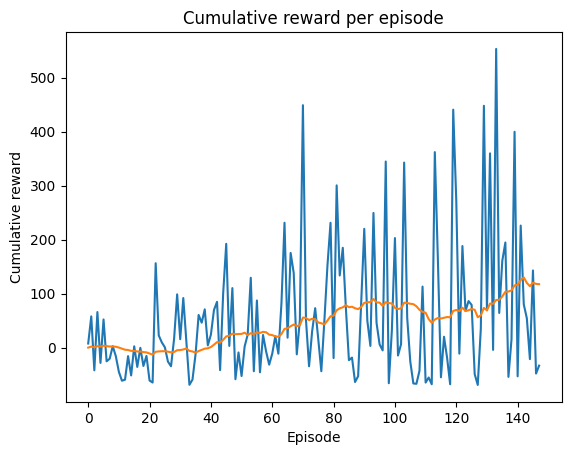

In [276]:
Q.plot_rewards_history(smoothing=30)

In [285]:
Q.get_state_visits((0, 0, 0, 0, 1))

1.1605090542131524

In [284]:
Q.search_Q((0, 0, 0, 0, 1))

{'LANE_LEFT': 72.14371059447907,
 'FASTER': 38.0264560854596,
 'SLOWER': 21.499707190440567,
 'LANE_RIGHT': 18.346160847401716,
 'IDLE': 13.341732155037946}

In [283]:
Q.test(sleep_time=0)

(0, 0, 0, 0, 0) LANE_RIGHT 2.7660428890572644 (0, 0, 0, 0, 0)
(0, 0, 0, 0, 0) LANE_RIGHT 2.8850761928973574 (0, 0, 0, 0, 0)
(0, 0, 0, 0, 0) LANE_RIGHT 3.192990859430143 (0, 0, 0, 0, 0)
(0, 0, 0, 0, 0) LANE_RIGHT 3.6102256069467646 (0, 0, 0, 0, 0)
(0, 0, 0, 0, 0) LANE_RIGHT 4.102682578290887 (0, 0, 0, 0, 0)
(0, 0, 0, 0, 0) LANE_RIGHT 4.70521064025497 (0, 0, 0, 0, 0)
(0, 0, 0, 0, 1) LANE_LEFT 5.070644783654647 (0, 0, 0, 0, 1)
(0, 0, 0, 0, 1) LANE_LEFT 4.368484879214952 (0, 0, 0, 0, 1)
(0, 0, 0, 0, 0) LANE_RIGHT 3.766243535382765 (0, 0, 0, 0, 0)
(0, 0, 0, 0, 0) LANE_RIGHT 4.3777330111106885 (0, 0, 0, 0, 0)
(0, 0, 0, 0, 0) LANE_RIGHT 4.284442650530519 (0, 0, 0, 0, 0)
(0, 0, 0, 0, 0) LANE_RIGHT 4.728702416950956 (0, 0, 0, 0, 0)
(0, 0, 0, 0, 1) LANE_LEFT 5.0743390857245485 (0, 0, 0, 0, 1)
(0, 0, 0, 0, 1) LANE_LEFT 4.36775467957 (0, 0, 0, 0, 1)
(0, 0, 0, 0, 0) LANE_RIGHT 3.7659095236243982 (0, 0, 0, 0, 0)
(0, 0, 1, 0, 0) LANE_RIGHT 4.377808419700306 (0, 0, 1, 0, 0)
(0, 0, 0, 0, 0) LANE_RIGHT 

In [ ]:
sar.train(m=100, verbose=2)

In [50]:
sar.search_Q((1, 0, 0, 1, -1))

{'FASTER': 5.133641775043947,
 'LANE_RIGHT': 1.8789156890532015,
 'SLOWER': 1.7437783264494309,
 'IDLE': 0.5959434836555192,
 'LANE_LEFT': -1.1294429580928238}

In [51]:
sar.test()

(0, 0, 0, 0, 0)
(0, 0, 0, 0, 0)
(0, 0, 0, 0, 0)
(0, 0, 0, 0, 0)
(0, 0, 0, 0, 0)
(0, 0, 0, 0, 0)
(0, 0, 0, 0, 0)
(0, 0, 0, 0, 0)
(0, 0, 0, 0, 0)
(0, 0, 1, 0, 0)
(0, 0, 1, 0, 0)
(0, 0, 0, 0, 1)
(0, 0, 0, 0, 1)
(0, 0, 0, 0, 1)
(0, 0, 0, 0, 1)
(0, 0, 1, 0, 1)
(0, 0, 1, 0, 1)
(0, 0, 1, 0, 1)
(0, 0, 1, 0, 1)
(0, 0, 1, 0, 1)
(0, 0, 1, 0, 1)
(0, 0, 1, 0, 1)
(0, 0, 0, 0, 1)
(0, 0, 0, 0, 1)
(0, 0, 0, 0, 1)
(0, 0, 1, 0, 1)
(0, 0, 1, 0, 1)
(0, 0, 1, 0, 1)
(0, 0, 1, 0, 1)
(0, 0, 1, 0, 1)
(1, 0, 1, 0, 1)
(1, 0, 1, 0, 1)


#### Observation testing kinematics

In [157]:
# Generate an episode of the environment and show the rewards and cumulative rewards
cum_reward = 0
with gym.make("highway-v0", config=kinematics, render_mode='human') as env:
    obs = env.reset()
    for _ in range(100):
        action = env.action_space.sample()
        obs, reward, done, truncated, info = env.step(action)
        cum_reward += reward
        # Print non-zero obs
        obs_non = obs[~np.all(obs == 0, axis=1)]
        print(reward)
        if done:
            break
        time.sleep(2)

50.03333333333333
20.127211934156396


KeyboardInterrupt: 

#### Time to collision

In [ ]:
class TimeToCollision:
    def __init__(horizon=5,
                policy_frequency=1,
                simulation_frequency=10):

        self.config = default_config.copy()
        self.config["observation"] =  {
        "type": "TimeToCollision",
        "horizon": horizon}
        self.config['policy_frequency'] = policy_frequency
        self.config['simulation_frequency'] = simulation_frequency

    def get_state(self, env): 
        grid = env.vehicle.speed_index
        return self.current_obs[grid]

    def test_env(self):
        with gym.make("highway-v0", config=self.config, render_mode='human') as env:
            obs = env.reset()
            for _ in range(1000):
                action = env.action_space.sample()
                obs, reward, done, truncated, info = env.step(action)
                print(self.get_state, reward)
                if done:
                    break
                time.sleep(1)

[[0.  0.  0.  0.5 1. ]
 [0.  0.  0.  0.  1. ]
 [0.  0.  0.  0.  0. ]]
[[0.  0.  0.  0.  0. ]
 [0.  0.  0.5 1.  1. ]
 [0.  0.  0.  0.  0. ]]
[[0.5 1.  1.  0.5 0. ]
 [0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0. ]]
[[0.  1.  1.  0.5 0. ]
 [0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0. ]]
[[0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0. ]
 [0.5 1.  1.  0.  0. ]]
[[0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0. ]
 [1.  1.  0.5 0.  0. ]]
[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
[[0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.5]]
[[0.  0.  0.  0.  0.5]
 [0.  0.  0.  0.  0. ]
 [0.  0.5 1.  1.  0. ]]
[[0.  0.  0.  0.  1. ]
 [0.  0.  0.  0.  0. ]
 [0.5 1.  1.  0.  0. ]]
[[0.  0.  0.  0.  0. ]
 [1.  1.  0.  0.  0. ]
 [0.  0.  0.  0.  0.5]]
